In [1]:
# 2枚の異なるfocus画像から奥行きを推定するプログラム
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [2]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = True
model = MyModel(channels=2)

PSIZE = 65
DEPTH_GAP = 100
weight_file = f"weights/weight_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)
model.eval()

MyModel(
  (conv1): Conv2d(2, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (bn64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [4]:
# 画像ペアから奥行きを推定するdataloader
class DepthEstimateData(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, IMGFILES, imsize, psize, channels, transforms):
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        
        # load file
        for fi in IMGFILES:
            img = Image.open(fi)
            img = img.convert('L')
            img = np.array(img).astype('float32')
            imgs.append(img)

        img = np.stack(imgs,axis=2)
        self.patch = []
        self.loc = []

        self.width = imsize[0]
        self.height = imsize[1]

        # 何ピクセルごとに推定するか? (高速化)
        self.STEP = 5
        
        for y in range(0,self.height-psize,self.STEP):
            for x in range(0,self.width-psize,self.STEP):
                patch = img[y:(y+psize),x:(x+psize)]
                self.patch.append(patch)
                self.loc.append([x,y])
    
    def __len__(self):
        return len(self.patch)

    def __getitem__(self, index):
        return self.transforms(self.patch[index]), self.loc[index]

In [5]:
# 対象となる画像データを読み出す (2 files)
#files = ["data/202410080808/10050.bmp", "data/202410080808/15050.bmp"]
DIR = "data/202410080819/"
files = [os.path.join(DIR,"10100.bmp"), os.path.join(DIR,"15100.bmp")]

imgs = []
psize = 65
width = 1600
height = 1200

trans = transforms.Compose([
    transforms.ToTensor()
])

dataset = DepthEstimateData(IMGFILES=files, imsize=[width,height], psize=psize, channels=2, transforms=trans) 
# データローダーの作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

In [6]:
outputs = []

for data,loc in dataloader:
    data = data.to(device)
    output = model(data).detach().cpu().numpy()
    outputs.append(output)

(array([3.000e+00, 7.000e+00, 1.700e+01, 2.700e+01, 2.900e+01, 3.900e+01,
        4.200e+01, 1.050e+02, 4.520e+02, 7.810e+02, 5.680e+02, 3.940e+02,
        3.160e+02, 3.510e+02, 5.130e+02, 7.330e+02, 7.260e+02, 6.060e+02,
        6.620e+02, 7.190e+02, 6.350e+02, 6.090e+02, 5.870e+02, 6.720e+02,
        5.950e+02, 5.390e+02, 5.700e+02, 6.050e+02, 5.640e+02, 5.260e+02,
        5.200e+02, 5.080e+02, 5.550e+02, 5.390e+02, 6.170e+02, 6.710e+02,
        7.780e+02, 9.590e+02, 1.082e+03, 1.131e+03, 1.455e+03, 2.094e+03,
        2.820e+03, 3.590e+03, 4.214e+03, 5.021e+03, 4.979e+03, 4.183e+03,
        3.435e+03, 2.963e+03, 2.540e+03, 2.065e+03, 1.770e+03, 1.368e+03,
        1.188e+03, 9.240e+02, 8.020e+02, 7.110e+02, 5.240e+02, 4.650e+02,
        3.610e+02, 3.250e+02, 2.750e+02, 2.020e+02, 1.810e+02, 1.320e+02,
        8.900e+01, 8.300e+01, 6.200e+01, 8.000e+01, 5.500e+01, 7.000e+01,
        6.500e+01, 3.900e+01, 4.900e+01, 2.900e+01, 2.400e+01, 1.600e+01,
        9.000e+00, 6.000e+00, 3.000e+0

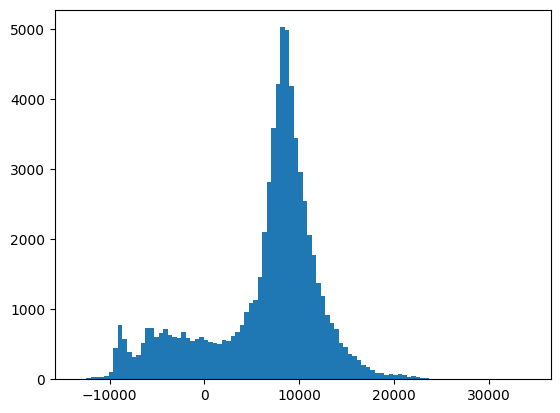

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

result = np.concatenate(outputs)
plt.hist(result, bins=100)

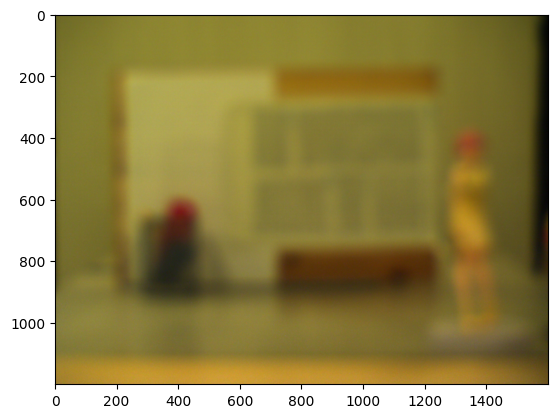

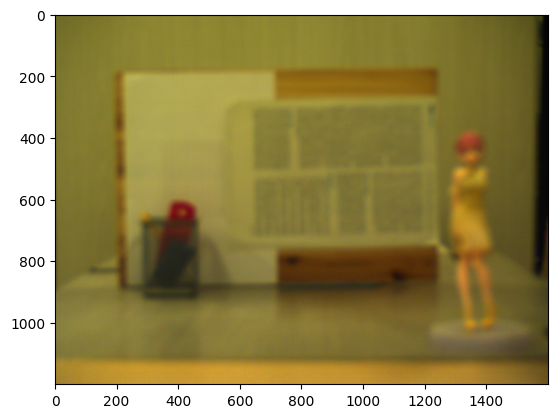

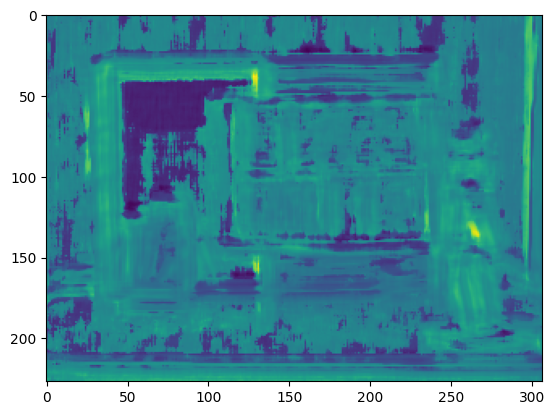

307 227 (227, 307)


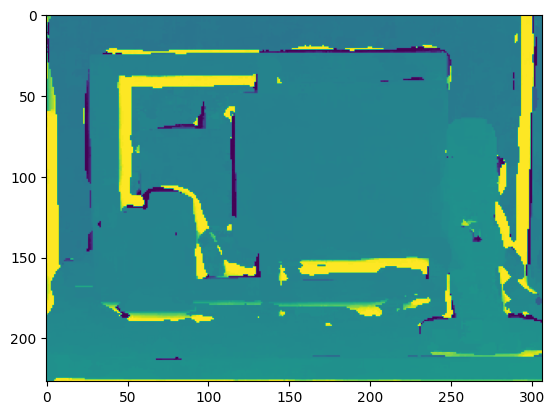

L1 error 4653248.373519897


In [23]:
import pickle, cv2

# 結果画像
ws = int((width - psize)/5)
hs = int((height - psize)/5)
result2 = result.reshape([hs,ws])

# 正解画像
with open(os.path.join(DIR,"depth.pkl"),'rb') as f:
    gt = pickle.load(f)

plt.imshow(Image.open(files[0]))
plt.show()
plt.imshow(Image.open(files[1]))
plt.show()
plt.imshow(result2)
plt.show()

# 結果画像をリサイズして表示
gt = gt[0:-1:5,0:-1:5]
print(ws,hs,gt.shape)
plt.imshow(gt)
plt.show()

# エラーを計算する
err = np.linalg.norm(gt-result2,ord=1)
print("L1 error", err)
